# Time-Series Classification: Collected Dataset
_by Mikhail Karasikov_

In [1]:
import urllib.request

dataset_name = 'VEHICLE'

testfile = urllib.request.URLopener()
testfile.retrieve("http://w17407.vdi.mipt.ru/ts_data/{}/dataset.mat".format(dataset_name),
                  "{}_dataset.mat".format(dataset_name))

('VEHICLE_dataset.mat', <http.client.HTTPMessage at 0x42e55f8>)

In [2]:
import numpy as np
import pandas
import multiclass
import timeseries
import feature_extraction

dataset = timeseries.TSDataset.load_from_mat("./{}_dataset.mat".format(dataset_name))
print("Dataset size: %d" % len(dataset))
print("Stats:\n", pandas.DataFrame([ts.shape for ts in dataset.ts],
                                   columns=['dim', 'len']).describe()[1:].round())

Dataset size: 188
Stats:
       dim  len
mean    4  276
std     0  145
min     4   10
25%     4  170
50%     4  225
75%     4  396
max     4  602


In [3]:
import sklearn.preprocessing

freq = 20

ts_smoothed = [
    timeseries.transform_frequency(ts[0], ts[1:], freq, kind='linear')[1]
    for ts in dataset.ts
]

X = timeseries.ExtractFeatures(ts_smoothed,
    lambda ts: ts.mean(1),
    lambda ts: ts.std(1),
    lambda ts: np.abs(ts - ts.mean(1).reshape(-1, 1)).mean(1),
    lambda ts: np.sqrt((ts ** 2).sum(0)).mean(),
    lambda ts: np.histogram(ts[0], density=True, bins=10)[0] * (ts[0].max() - ts[0].min()) / 10,
    lambda ts: np.histogram(ts[1], density=True, bins=10)[0] * (ts[1].max() - ts[1].min()) / 10,
    lambda ts: np.histogram(ts[2], density=True, bins=10)[0] * (ts[2].max() - ts[2].min()) / 10,
    lambda ts: feature_extraction.ar_parameters(ts, np.arange(1, 5)),
    lambda ts: feature_extraction.dft_features(np.sqrt((ts[:3] ** 2).sum(0)), 5)[1:]
)

X_normalized = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)
X_normalized.shape

(188, 63)

[Parallel(n_jobs=2)]: Done   1 jobs       | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done  50 jobs       | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done 200 jobs       | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done 450 jobs       | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done 800 jobs       | elapsed:    7.3s
[Parallel(n_jobs=2)]: Done 1250 jobs       | elapsed:   10.4s
[Parallel(n_jobs=2)]: Done 1800 jobs       | elapsed:   13.7s
[Parallel(n_jobs=2)]: Done 2450 jobs       | elapsed:   17.9s
[Parallel(n_jobs=2)]: Done 2998 out of 3000 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 3000 out of 3000 | elapsed:   21.0s finished


Fitting 30 folds for each of 100 candidates, totalling 3000 fits
Best score: 0.902666666667 
Best parameters: {'gamma': 0.12915496650148828, 'C': 10.0}


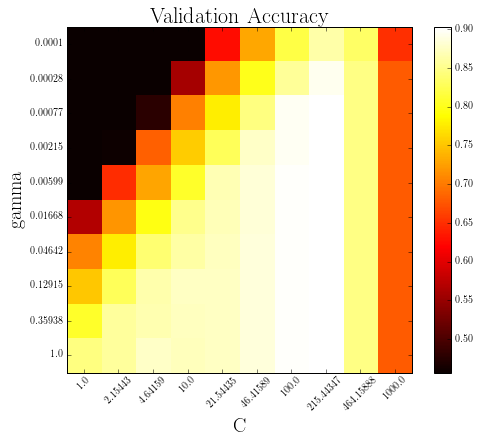

In [4]:
from sklearn.grid_search import GridSearchCV
from sklearn import svm, cross_validation
import multiclass
%matplotlib inline

indices = np.array([label != '?' and label != '1METRO' for label in dataset.label])

grid_search_cv = GridSearchCV(
    svm.SVC(),
    {
        'gamma': np.logspace(-4, 0, 10),
        'C': np.logspace(0, 3, 10),
    },
    scoring=None,
    n_jobs=2,
    refit=False,
    cv=cross_validation.ShuffleSplit(dataset.label[indices].size, n_iter=30, test_size=0.3, random_state=17),
    verbose=1,
    error_score='raise'
).fit(X_normalized[indices], dataset.label[indices])

print('Best score:', grid_search_cv.best_score_, '\nBest parameters:', grid_search_cv.best_params_)
multiclass.plot_grid_search_scores(grid_search_cv)

........................................................................................................................................................................................................
Mean accuracy: 0.901
Confusion matrix:
 [[ 0.86  0.11  0.03]
 [ 0.04  0.94  0.01]
 [ 0.09  0.02  0.88]]


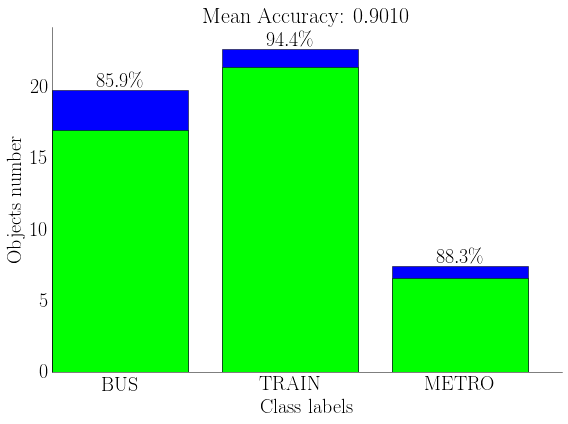

In [5]:
confusion_mean = multiclass.cross_val_score(
    svm.SVC(**grid_search_cv.best_params_),
    X_normalized[indices], dataset.label[indices],
    cross_validation.ShuffleSplit(dataset.label[indices].size, n_iter=200, test_size=0.3, random_state=17)
)